In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import InceptionResNetV2

from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers, Sequential
from keras.layers.normalization import BatchNormalization
from keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
batch_size = 64

In [5]:
# rescale normalizes the data for the images.
# Data is split into train and validation sets
image_data_gen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    validation_split=0.2)

train_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TB_Chest_Radiography_Database',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              subset='training'
                                             )

val_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TB_Chest_Radiography_Database',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle = False,
                                              subset='validation'
                                             )

test_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TestImages for TB',
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              shuffle = False,
                                              class_mode='binary',
                                            )

Found 5440 images belonging to 2 classes.
Found 1360 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [6]:
InceptionV3_model = tf.keras.applications.InceptionV3(
    include_top=False,
    input_tensor=None,
    input_shape=(224,224,3),
    weights = 'imagenet'
)

InceptionV3_model.trainable= False

global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
predictions = Dense(1, activation='sigmoid')

model = Sequential([
    InceptionV3_model,
    global_avg_layer,
    
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    predictions
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________

In [7]:
epochs = 10
histort = model.fit(train_it,
                    validation_data=val_it, 
                    epochs=epochs )
model.save('/content/drive/MyDrive/InceptionV3.h5')

Epoch 1/10
85/85 [==============================] - 4401s 51s/step - loss: 0.4327 - accuracy: 0.8311 - val_loss: 0.4532 - val_accuracy: 0.8096
Epoch 2/10
85/85 [==============================] - 142s 2s/step - loss: 0.2691 - accuracy: 0.8960 - val_loss: 0.2665 - val_accuracy: 0.8868
Epoch 3/10
85/85 [==============================] - 141s 2s/step - loss: 0.2063 - accuracy: 0.9167 - val_loss: 0.2108 - val_accuracy: 0.9140
Epoch 4/10
85/85 [==============================] - 139s 2s/step - loss: 0.1853 - accuracy: 0.9249 - val_loss: 0.1630 - val_accuracy: 0.9375
Epoch 5/10
85/85 [==============================] - 139s 2s/step - loss: 0.1772 - accuracy: 0.9291 - val_loss: 0.1638 - val_accuracy: 0.9360
Epoch 6/10
85/85 [==============================] - 140s 2s/step - loss: 0.1645 - accuracy: 0.9313 - val_loss: 0.1669 - val_accuracy: 0.9331
Epoch 7/10
85/85 [==============================] - 140s 2s/step - loss: 0.1587 - accuracy: 0.9330 - val_loss: 0.1393 - val_accuracy: 0.9456
Epoch 8/10


In [8]:
results = model.evaluate(val_it)

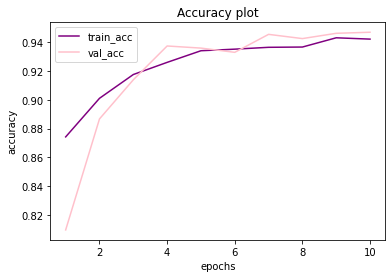

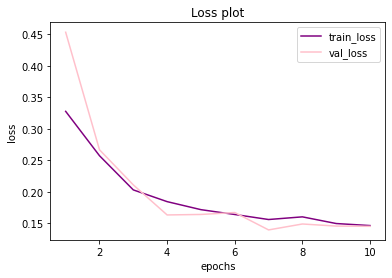

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
epochs= range(1, len(histort.history["accuracy"])+1)

plt.plot(epochs, histort.history["accuracy"], color="purple")
plt.plot(epochs, histort.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, histort.history["loss"], color="purple")
plt.plot(epochs, histort.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [10]:
results = model.evaluate(val_it)

22/22 [==============================] - 29s 1s/step - loss: 0.1465 - accuracy: 0.9412


In [11]:

prediction= model.predict(val_it, verbose=2)
prediction= (prediction > 0.5)
prediction

22/22 - 27s


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [12]:
val_labels=val_it.classes
val_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

0.9338235294117647
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       680
           1       0.95      0.91      0.93       680

    accuracy                           0.93      1360
   macro avg       0.93      0.93      0.93      1360
weighted avg       0.93      0.93      0.93      1360



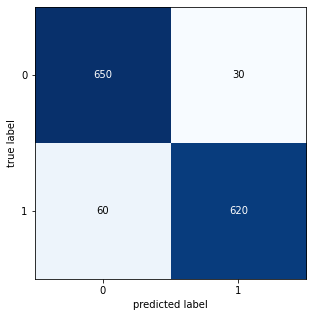

In [13]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(val_it.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))
print(accuracy_score(val_it.classes, prediction))
print(classification_report(val_it.classes, prediction))

In [14]:
results = model.evaluate(test_it)


4/4 [==============================] - 88s 29s/step - loss: 0.0782 - accuracy: 0.9700


In [15]:
prediction1 = model.predict(test_it)
prediction1 = (prediction1 > 0.5)
prediction1

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

0.97
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       100
           1       0.98      0.96      0.97       100

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



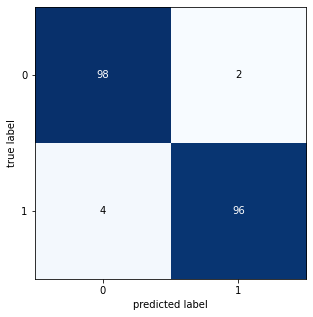

In [16]:
cm1 = confusion_matrix(test_it.classes, prediction1)
plot_confusion_matrix(cm1, figsize=(5,5))
print(accuracy_score(test_it.classes, prediction1))
print(classification_report(test_it.classes, prediction1))